In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import starry

starry.config.lazy = False

In [3]:
print(starry.__version__)

1.0.0


In [4]:
# Regular maps
map = starry.Map(ydeg=6, udeg=2, drorder=1)
npts = 1000

def get_rank(inc=90, u=[0, 0], alpha=0.0, **kwargs):
    map.inc = inc
    map[1:] = u
    map.alpha = alpha
    A = map.design_matrix(**kwargs)
    return np.linalg.matrix_rank(A.T.dot(A))

Differential rotation is still an experimental feature. Use it with care.
Pre-computing some matrices... Done.


In [5]:
# Reflected light maps
rmap = starry.Map(ydeg=6, reflected=True)
rmap.inc = 60
phase = np.linspace(0, 360, npts)
xs, ys, zs = [np.sin(np.pi / 180 * phase), np.zeros_like(phase), np.cos(np.pi / 180 * phase)]
theta = np.linspace(0, 365.25 * 360, npts)
A = rmap.design_matrix(theta=theta, xs=xs, ys=ys, zs=zs)
rank_reflected = np.linalg.matrix_rank(A.T.dot(A))

Pre-computing some matrices... Done.
Compiling `X`... Done.
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [6]:
# Doppler maps
# Need to run as a subprocess b/c starry.config.lazy = True
code = \
"""
from scipy.sparse import block_diag
import paparazzi as pp
import numpy as np
dop = pp.Doppler(ydeg=6, inc=60)
dop.generate_data()  
V = block_diag([dop.s_true.reshape(-1, 1) for n in range(dop.N)])
A = np.array(dop.D().dot(V).todense())
print(np.linalg.matrix_rank(A.T.dot(A)))
"""
code = ("; ").join(code.split("\n")[1:-1])
import subprocess
rank_doppler = int(subprocess.check_output(["python", "-c", code])[-3:])

In [7]:
params = {
    "phase curve": {
        "edge-on": dict(theta=np.linspace(0, 360, npts)),
        "inclined": dict(inc=60, theta=np.linspace(0, 360, npts)),
        "edge-on, diff. rot.": dict(alpha=0.1, theta=np.linspace(0, 360, npts)),
        "inclined, diff. rot.": dict(
            inc=60, alpha=0.1, theta=np.linspace(0, 360, npts)
        ),
    },
    "transit": {
        "r=0.01, b=0": dict(ro=0.01, xo=np.linspace(-1.5, 1.5, npts)),
        "r=0.01, b=0.75": dict(
            ro=0.01, xo=np.linspace(-1.5, 1.5, npts), yo=0.75
        ),
        "r=0.25, b=0": dict(ro=0.25, xo=np.linspace(-1.5, 1.5, npts)),
        "r=0.25, b=0.75": dict(
            ro=0.25, xo=np.linspace(-1.5, 1.5, npts), yo=0.75
        ),
    },
    "transit + phase curve": {
        "r=0.01, b=0": dict(
            ro=0.01, xo=np.linspace(-1.5, 1.5, npts), theta=np.linspace(0, 360, npts)
        ),
        "r=0.01, b=0.75": dict(
            ro=0.01,
            xo=np.linspace(-1.5, 1.5, npts),
            yo=0.75,
            theta=np.linspace(0, 360, npts),
        ),
        "r=0.25, b=0": dict(
            ro=0.25, xo=np.linspace(-1.5, 1.5, npts), theta=np.linspace(0, 360, npts)
        ),
        "r=0.25, b=0.75": dict(
            ro=0.25,
            xo=np.linspace(-1.5, 1.5, npts),
            yo=0.75,
            theta=np.linspace(0, 360, npts),
        ),
    },
    "occultation": {
        "r=1, b=1.75": dict(ro=1, xo=np.linspace(-2.5, 2.5, npts), yo=1.75),
        "r=10, b=0.01": dict(ro=10, xo=np.linspace(-11, 11, npts), yo=0.01),
        "r=10, b=8": dict(ro=10, xo=np.linspace(-11, 11, npts), yo=8),
        "r=1, b=0.01": dict(
            ro=1, xo=np.linspace(-2.5, 2.5, npts), yo=0.01
        )
    },
    "occultation + phase curve": {
        "r=1, b=1.75": dict(
            ro=1,
            xo=np.linspace(-2.5, 2.5, npts),
            yo=1.75,
            theta=np.linspace(0, 360, npts),
        ),
        "r=10, b=0.01": dict(
            ro=10,
            xo=np.linspace(-11, 11, npts),
            yo=0.01,
            theta=np.linspace(0, 360, npts),
        ),
        "r=10, b=8": dict(
            ro=10, xo=np.linspace(-11, 11, npts), yo=8, theta=np.linspace(0, 360, npts)
        ),
        "r=1, b=0.01": dict(
            ro=1,
            xo=np.linspace(-2.5, 2.5, npts),
            yo=0.01,
            theta=np.linspace(0, 360, npts),
        ),
    },
}

In [8]:
# Compute the ranks
category = []
description = []
rank = []
for cat, p in params.items():
    for desc, kwargs in p.items():
        category.append(cat)
        description.append(desc)
        rank.append(get_rank(**kwargs))
    category.append("")
    description.append("")
    rank.append(np.nan)

# Append the *doppler* rank
category.append("doppler")
description.append("doppler")
rank.append(rank_doppler)
    
# Append the *reflected light* rank
category.append("reflected")
description.append("reflected")
rank.append(rank_reflected)

# Numpyfy
rank = np.array(rank)
category = np.array(category)
description = np.array(description)

Compiling `X`... Done.
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [9]:
def color(category):
    color = []
    for cat in category:
        if cat == "phase curve":
            color.append("C0")
        elif cat == "transit":
            color.append("C1")
        elif cat == "transit + phase curve":
            color.append("C2")
        elif cat == "occultation":
            color.append("C3")
        elif cat == "occultation + phase curve":
            color.append("C4")
        elif cat == "doppler":
            color.append("C6")
        elif cat == "reflected":
            color.append("C6")
        else:
            color.append("C6")
    return color

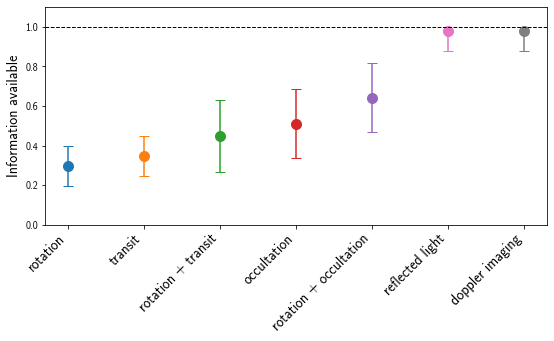

In [20]:
fig, ax = plt.subplots(1, figsize=(9, 4))
info = rank / map.Ny
indices = np.arange(len(info))
inds = [slice(0, 4), slice(5, 9), slice(10, 14), slice(15, 19), slice(20, 24), [25, 25], [26, 26]]

color = ["C0", "C1", "C2", "C3", "C4", "C6", "C7"]
labels = ["rotation", "transit", "rotation + transit", "occultation", "rotation + occultation", "reflected light", "doppler imaging"]
for n, i in enumerate(inds):
    ax.plot(n, np.mean(info[i]), "o", color=color[n], ms=10)
    yerr = 0.5 * (np.max(info[i]) - np.min(info[i]))
    if yerr == 0:
        # hack
        yerr = np.array([[0.1], [0]])
    ax.errorbar(n, np.mean(info[i]), yerr=yerr, color=color[n], capsize=5)

ax.axhline(1.0, color="k", ls="--", lw=1)
ax.set_ylim(0, 1.1)
ax.set_xticks(range(7))
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=14);
ax.set_ylabel("Information available", fontsize=14);

fig.savefig("/Users/rluger/Desktop/rank.pdf", bbox_inches="tight")